# Data pre-processing

Pre-processing of data from notebook [Data Process](./dataProcess.ipynb)

In [2]:
%%capture

import sys
!{sys.executable} -m pip install nbformat

%run -G ./preprocessor.py

## First Model Building and Evaluation

Training and evaluation using Logistic Regression will be used as a first model.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score

In [4]:
df

,V1,V2,V3,V4,V5,V6,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V20,Hour,Class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.475312,0.510600,0.252484,0.680908,0.635591,0.434392,0.737173,0.655066,0.594863,0.582942,0.0,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.453981,0.505267,0.381188,0.744342,0.641219,0.464105,0.727794,0.640681,0.551930,0.579530,0.0,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.410603,0.513018,0.322422,0.706683,0.640473,0.357443,0.763381,0.644945,0.386683,0.585855,0.0,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.414999,0.507585,0.271817,0.710910,0.636372,0.415653,0.711253,0.788492,0.467058,0.578050,0.0,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.490950,0.524303,0.236355,0.724477,0.608406,0.434995,0.724243,0.650665,0.626060,0.584615,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283721,0.756448,0.873531,0.666991,0.160317,0.729603,0.236810,0.235393,0.528729,0.598850,0.190550,0.806406,0.801627,0.484577,0.789000,0.688412,0.509985,0.595979,1.0,0
283722,0.945845,0.766677,0.872678,0.219189,0.771561,0.273661,0.265504,0.482925,0.488530,0.276355,0.738709,0.623352,0.426717,0.730383,0.569303,0.442620,0.580900,1.0,0
283723,0.990905,0.764080,0.781102,0.227202,0.783425,0.293496,0.263547,0.477677,0.498692,0.309763,0.706572,0.628885,0.453827,0.740239,0.680504,0.518236,0.580280,1.0,0
283724,0.954209,0.772856,0.849587,0.282508,0.763172,0.269291,0.261175,0.476287,0.500464,0.170288,0.667901,0.661171,0.429998,0.745946,0.729908,0.789612,0.581622,1.0,0


Ploting the correlation matrix again shows how correlated features are, aiding in determining if PCA is adequate.

<AxesSubplot:>

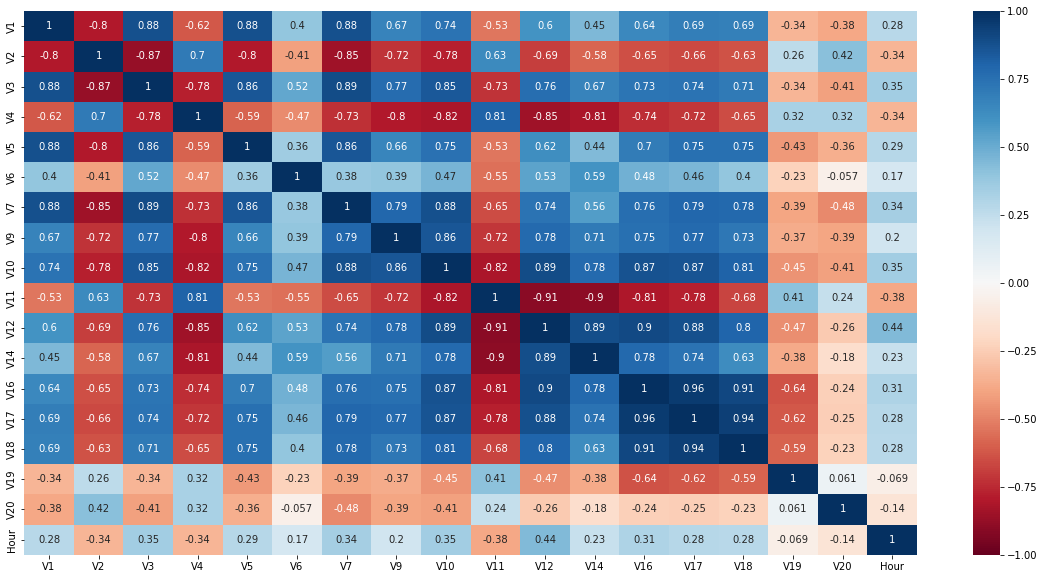

In [5]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
df_overSampled, y_overSampled = smote.fit_resample(X=df, y=df['Class'])
df_overSampled = df_overSampled.drop(['Class'], axis=1)
corr = df_overSampled.corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, annot=True, cmap= 'RdBu')

In [6]:

X = df.drop('Class', axis=1)
y = df['Class']
print(X.shape)
print(y.shape)


(283726, 18)
(283726,)


Correlation matrix plots shows features are strongly correlated. Therefore, an analysis of how PCA dimensionality reduction effects the logistic regression model is done.

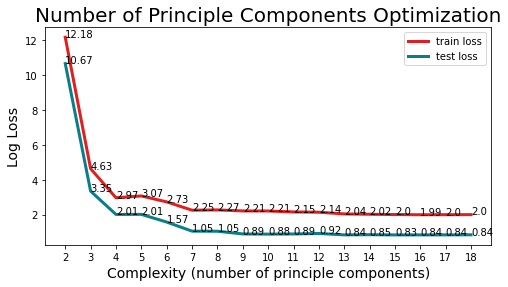

In [8]:
from sklearn import decomposition
loss_train_df = []
loss_test_df = []

from imblearn.under_sampling import RandomUnderSampler

for k in range(2, 19):
    X = df.drop('Class', axis=1)
    y = df['Class']
    logisticRegr = LogisticRegression(max_iter=1200)
    pca = decomposition.PCA(n_components=k)
    pca.fit(X)
    X = pca.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    #Oversample the train set
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    logisticRegr.fit(X_train, y_train)
    train_predictions = logisticRegr.predict(X_train)
    test_predictions = logisticRegr.predict(X_test)

    loss_train = log_loss(y_train, train_predictions)
    loss_test = log_loss(y_test, test_predictions)
    loss_train_df.append({'k': k, 'loss': loss_train})
    loss_test_df.append({'k': k, 'loss': loss_test})

loss_train_df = pd.DataFrame(loss_train_df)
loss_test_df = pd.DataFrame(loss_test_df)


plt.figure(figsize=(8, 4))
plt.plot(loss_train_df['k'], loss_train_df['loss'], lw=3, c='#e31e1e', label='train loss')
for a,b in zip(loss_train_df['k'], loss_train_df['loss']): 
    plt.text(a, b, str(round(b, 2)))
plt.plot(loss_test_df['k'], loss_test_df['loss'], lw=3, c='#087E8B', label='test loss')
for a,b in zip(loss_test_df['k'], loss_test_df['loss']): 
    plt.text(a, b, str(round(b, 2)))
plt.title("Number of Principle Components Optimization", size=20)
plt.xlabel('Complexity (number of principle components)', size=14)
plt.xticks(np.arange(2, k+1, 1))
plt.ylabel('Log Loss', size=14)
plt.legend()
plt.show()

Seeing as both test and train loss flatten, i.e., are not changed substantially, post n_components=7, this choice of parameter seems satisfactory (satisfactory meaning the dimension of the original data is reduced, however, most performance is still retained).

Next, to obtain another point of view of how complexity affects performance, adding different degrees of polynomial features to the Logistic Regression Model is done.

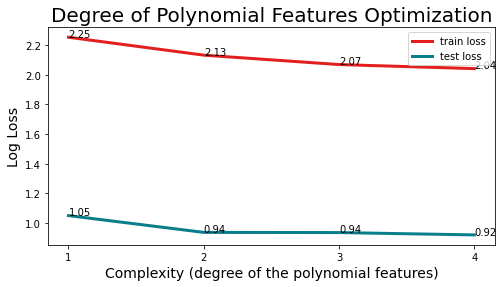

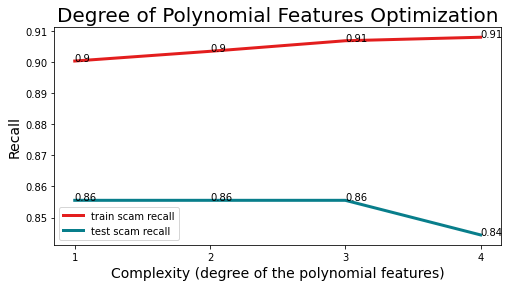

In [9]:
X = df.drop('Class', axis=1)
y = df['Class']

pca = decomposition.PCA(n_components=7)
pca.fit(X)
X = pca.transform(X)

loss_train_df = []
loss_test_df = []
recall_train_df = []
recall_test_df = []

for k in range(1, 5):
    logisticRegr = LogisticRegression(max_iter=1200)
    X_poly = PolynomialFeatures(k).fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
    #remember to oversample
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    logisticRegr.fit(X_train, y_train)
    train_predictions = logisticRegr.predict(X_train)
    test_predictions = logisticRegr.predict(X_test)

    loss_train = log_loss(y_train, train_predictions)
    loss_test = log_loss(y_test, test_predictions)
    loss_train_df.append({'k': k, 'loss': loss_train})
    loss_test_df.append({'k': k, 'loss': loss_test})

    recall_train = recall_score(y_train, train_predictions)
    recall_test = recall_score(y_test, test_predictions)
    recall_train_df.append({'k': k, 'recall': recall_train})
    recall_test_df.append({'k': k, 'recall': recall_test})

loss_train_df = pd.DataFrame(loss_train_df)
loss_test_df = pd.DataFrame(loss_test_df)

recall_train_df = pd.DataFrame(recall_train_df)
recall_test_df = pd.DataFrame(recall_test_df)

# Plot log loss
plt.figure(figsize=(8, 4))
plt.plot(loss_train_df['k'], loss_train_df['loss'], lw=3, c='#e31e1e', label='train loss')
for a,b in zip(loss_train_df['k'], loss_train_df['loss']): 
    plt.text(a, b, str(round(b, 2)))
plt.plot(loss_test_df['k'], loss_test_df['loss'], lw=3, c='#087E8B', label='test loss')
for a,b in zip(loss_test_df['k'], loss_test_df['loss']): 
    plt.text(a, b, str(round(b, 2)))
plt.title(f"Degree of Polynomial Features Optimization", size=20)
plt.xlabel('Complexity (degree of the polynomial features)', size=14)
plt.xticks(np.arange(1, k+1, 1))
plt.ylabel('Log Loss', size=14)
plt.legend()
plt.show()

# Plot recall
plt.figure(figsize=(8, 4))
plt.plot(recall_train_df['k'], recall_train_df['recall'], lw=3, c='#e31e1e', label='train scam recall')
for a,b in zip(recall_train_df['k'], recall_train_df['recall']): 
    plt.text(a, b, str(round(b, 2)))
plt.plot(recall_test_df['k'], recall_test_df['recall'], lw=3, c='#087E8B', label='test scam recall')
for a,b in zip(recall_test_df['k'], recall_test_df['recall']): 
    plt.text(a, b, str(round(b, 2)))
plt.title(f"Degree of Polynomial Features Optimization", size=20)
plt.xlabel('Complexity (degree of the polynomial features)', size=14)
plt.xticks(np.arange(1, k+1, 1))
plt.ylabel('Recall', size=14)
plt.legend()
plt.show()

#### Complexity conclusions

From the graphs above, it is evident that increasing the dimension of the data, i.e., adding polynomial features, the train loss decreases whilst the test loss remains largely the same. Additionally, a decrease in scam recall on the test data is visible with increasing complexity. Therefore, the conclusion can be drawn that increasing the dimension of the data by introducing polynomial features is inadequate, as it increases the model's risk of overfitting.

An interesting observation is that the test loss is less than the train loss, whilst the typical case is the other way around. An explanation for this unordinary finding can be found in the imbalanced nature of the input data, where there are many non-fradulent transactions for every fraudulent one (which led to us oversampling the data in the data processing stage).

However, the same oversampling is not done to the test data, resulting in it still having many more negative cases. Therefore, an underfitting model would be close to classifying all test cases as non-fraudulent, however, still resulting in a quite low loss (since there are only a few fraudulent cases present in the test data, the log-loss function will not penalize it severely).

In [10]:
X = df.drop('Class', axis=1)
y = df['Class']
logisticRegr = LogisticRegression(max_iter=1200)

pca = decomposition.PCA(n_components=7)
pca.fit(X)
X = pca.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [11]:
logisticRegr.fit(X_train, y_train)
train_predictions = logisticRegr.predict(X_train)
test_predictions = logisticRegr.predict(X_test)

### Train results

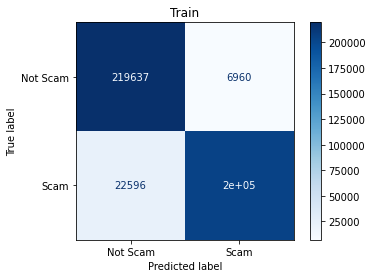

              precision    recall  f1-score   support

           0       0.91      0.97      0.94    226597
           1       0.97      0.90      0.93    226597

    accuracy                           0.93    453194
   macro avg       0.94      0.93      0.93    453194
weighted avg       0.94      0.93      0.93    453194



In [12]:
cm = confusion_matrix(y_train, train_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Scam', 'Scam'])
disp.plot(cmap='Blues')
plt.title('Train')
plt.show() 

cr = classification_report(y_train,train_predictions)
print(cr)

### Test results

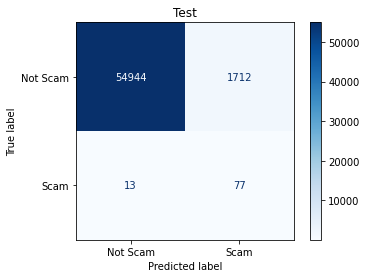

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56656
           1       0.04      0.86      0.08        90

    accuracy                           0.97     56746
   macro avg       0.52      0.91      0.53     56746
weighted avg       1.00      0.97      0.98     56746



In [13]:
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Scam', 'Scam'])
disp.plot(cmap='Blues')
plt.title('Test')
plt.show() 

cr = classification_report(y_test,test_predictions)
print(cr)

#### Confusion matrix conclusions

The test results showed a high, 97%, accuracy for the model. However, an 86% recall on scam (fraudulent) transactions, and a 4% precision, is not satisfactory, as the goal of our model is to classify near all fradulent transactions correctly (low false-negatives), whilst more non-fraudulent being classified as fraudulent (false-positives) is okay. These test results show that this model would miss 14% of the fradulent transactions, a number that should be reduced before entering production.

As previously discussed, false-negatives implies fraudulent transactions being allowed (bad in the real world), whilst false-positives only denies a legitimate purchase (which leads to an unhappy customer, but it is a trade-off that helps to reduce fraud). 